In [1]:
# The BEDPEs are given in the GEO

!Rscript GI.R.edges.r -i data/ALL_H3K27ac_Vh.tmm.bedpe -b data/CRE.bed -o data/G/H3K27ac_Vh.tsv
!Rscript GI.R.edges.r -i data/ALL_H3K27ac_30m.tmm.bedpe -b data/CRE.bed -o data/G/H3K27ac_30m.tsv
!Rscript GI.R.edges.r -i data/ALL_H3K27ac_4h.tmm.bedpe -b data/CRE.bed -o data/G/H3K27ac_4h.tsv
!Rscript GI.R.edges.r -i data/ALL_H3K27ac_16h.tmm.bedpe -b data/CRE.bed -o data/G/H3K27ac_16h.tsv
!Rscript GI.R.edges.r -i data/ALL_H3K27ac_72h.tmm.bedpe -b data/CRE.bed -o data/G/H3K27ac_72h.tsv
!Rscript GI.R.edges.r -i data/ALL_H3K4me3_Vh.tmm.bedpe -b data/CRE.bed -o data/G/H3K4me3_Vh.tsv
!Rscript GI.R.edges.r -i data/ALL_H3K4me3_30m.tmm.bedpe -b data/CRE.bed -o data/G/H3K4me3_30m.tsv
!Rscript GI.R.edges.r -i data/ALL_H3K4me3_4h.tmm.bedpe -b data/CRE.bed -o data/G/H3K4me3_4h.tsv
!Rscript GI.R.edges.r -i data/ALL_H3K4me3_16h.tmm.bedpe -b data/CRE.bed -o data/G/H3K4me3_16h.tsv
!Rscript GI.R.edges.r -i data/ALL_H3K4me3_72h.tmm.bedpe -b data/CRE.bed -o data/G/H3K4me3_72h.tsv


Warning message:
In makeGenomicInteractionsFromFile(interactions, type = "bedpe",  :
  Some counts are set to zero, bedpe score field may represent other data
Annotating with cre ...
Warning message:
In annotateInteractions(pet, annotation.features) :
  Some features contain duplicate IDs which will result in duplicate annotations
       category  count
1 distal-distal  47614
2    distal-cre 287762
3       cre-cre 239441
None
Warning message:
In makeGenomicInteractionsFromFile(interactions, type = "bedpe",  :
  Some counts are set to zero, bedpe score field may represent other data
Annotating with cre ...
Warning message:
In annotateInteractions(pet, annotation.features) :
  Some features contain duplicate IDs which will result in duplicate annotations
       category  count
1 distal-distal  47614
2    distal-cre 287762
3       cre-cre 239441
None
Warning message:
In makeGenomicInteractionsFromFile(interactions, type = "bedpe",  :
  Some counts are set to zero, bedpe score field may re

In [2]:
import numpy as np
import pandas as pd
import networkx as nx

import pybedtools as bt

from collections import Counter, deque
import pickle
import re
import os

from mycolorpy import colorlist as mcp
import matplotlib.patches as mpatches
import matplotlib.collections as mcol
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec
from scipy.stats import shapiro, mannwhitneyu


from adjustText import adjust_text

color1=mcp.gen_color(cmap="Reds",n=10)[-7:-2]
color2=mcp.gen_color(cmap="Greys",n=10)[-7:-2]


colorPalette = {
    "ANDR"    : color1[-1],
    "High"    : color2[-1],
    "Mid-high": color2[-2],
    "Mid-low" : color2[-3],
    "low"     : color2[-4],
    
    "ARcre"   : "#F19322",
    "cre"     : "#888888"
}

MAPty = pickle.load(open('zenodo/MAPty.p', 'rb'))
MAPcl = pickle.load(open('zenodo/MAPcl.p', 'rb'))
MAPgn = pickle.load(open('zenodo/MAPgn.p', 'rb'))

In [3]:
DFs = pd.DataFrame()
first = True
for s in ['H3K27ac', 'H3K4me3']:
    for t in ["Vh","30m","4h", "16h","72h"]:
        
        interactions = f"data/G/{s}_{t}.tsv"
        df = pd.read_table(interactions)
        df = df.rename(columns={'counts': f'{s}.{t}'})
        
        if first:
            DFs = df
            first = False
        else:
            DFs[f'{s}.{t}'] = df[f'{s}.{t}']
            
            
G = nx.Graph()

for i, row in DFs.iterrows():

    # >>> 1 >>>
    if row["cre.id1"].find("['") != -1:        
        s1 = row["cre.id1"].replace("['", "")
        s1 = s1.replace("']", "")
        s1 = s1.split("', '")
    else:
        s1 = [row["cre.id1"]]

    if row["cre.id2"].find("['") != -1:
        s2 = row["cre.id2"].replace("['", "")
        s2 = s2.replace("']", "")
        s2 = s2.split("', '")
    else:
        s2 = [row["cre.id2"]]

    # <<< 1 <<<
    
    # >>> 2 (3) >>>
    c = {}
    for w in ['H3K27ac.Vh', 'H3K27ac.30m', 'H3K27ac.4h', 'H3K27ac.16h', 'H3K27ac.72h', 'H3K4me3.Vh', 'H3K4me3.30m', 'H3K4me3.4h', 'H3K4me3.16h', 'H3K4me3.72h']:
        c[w] = row[w]

    for s1_ in s1:
        for s2_ in s2:
            

            nc1 = MAPcl[s1_]
            nc2 = MAPcl[s2_]
            G.add_node(s1_, nodeClass=nc1,color=colorPalette[nc1])
            G.add_node(s2_, nodeClass=nc2,color=colorPalette[nc2])
            
            if s1_ == s2_:
                continue
            G.add_edge(s1_, s2_, **c,)
            
    # <<< 2 (3) <<<
# <<< 2 <<<

pickle.dump(G, open('zenodo/G_ALL.p', 'wb'))

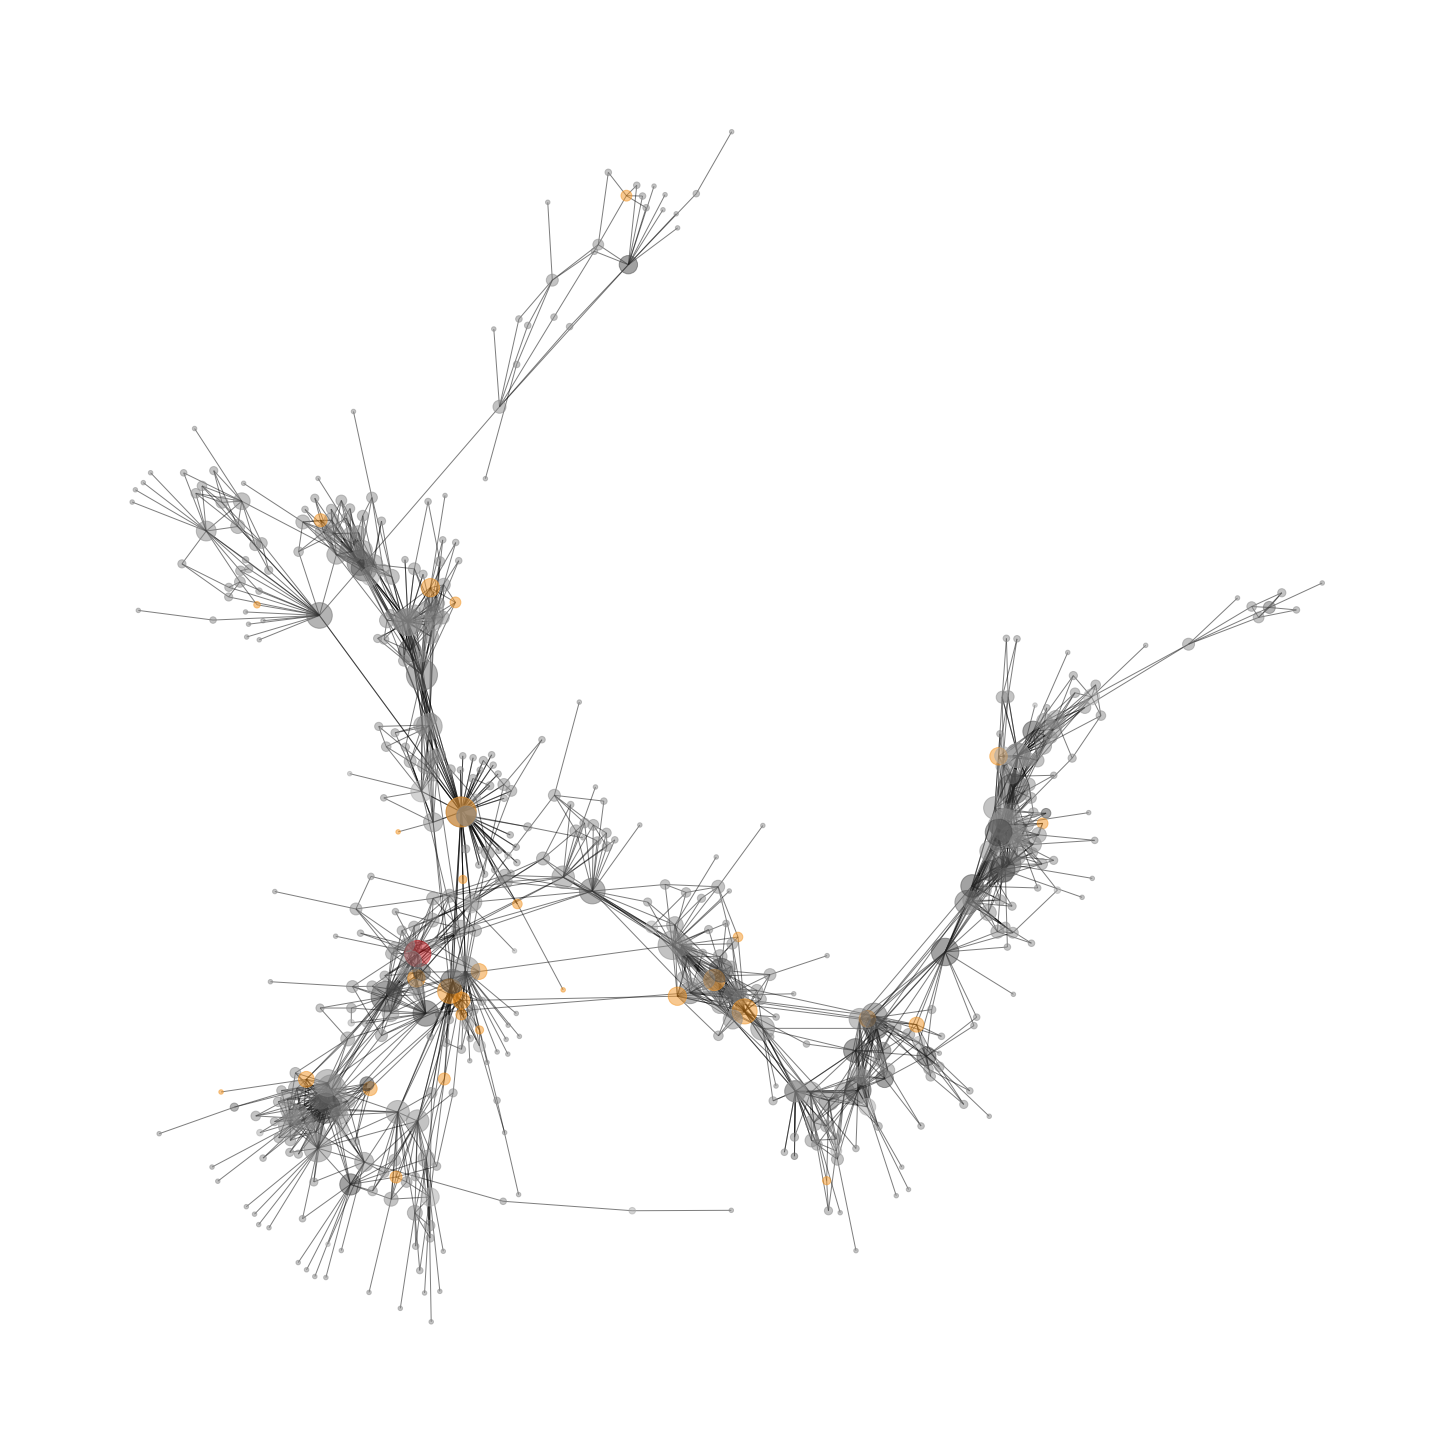

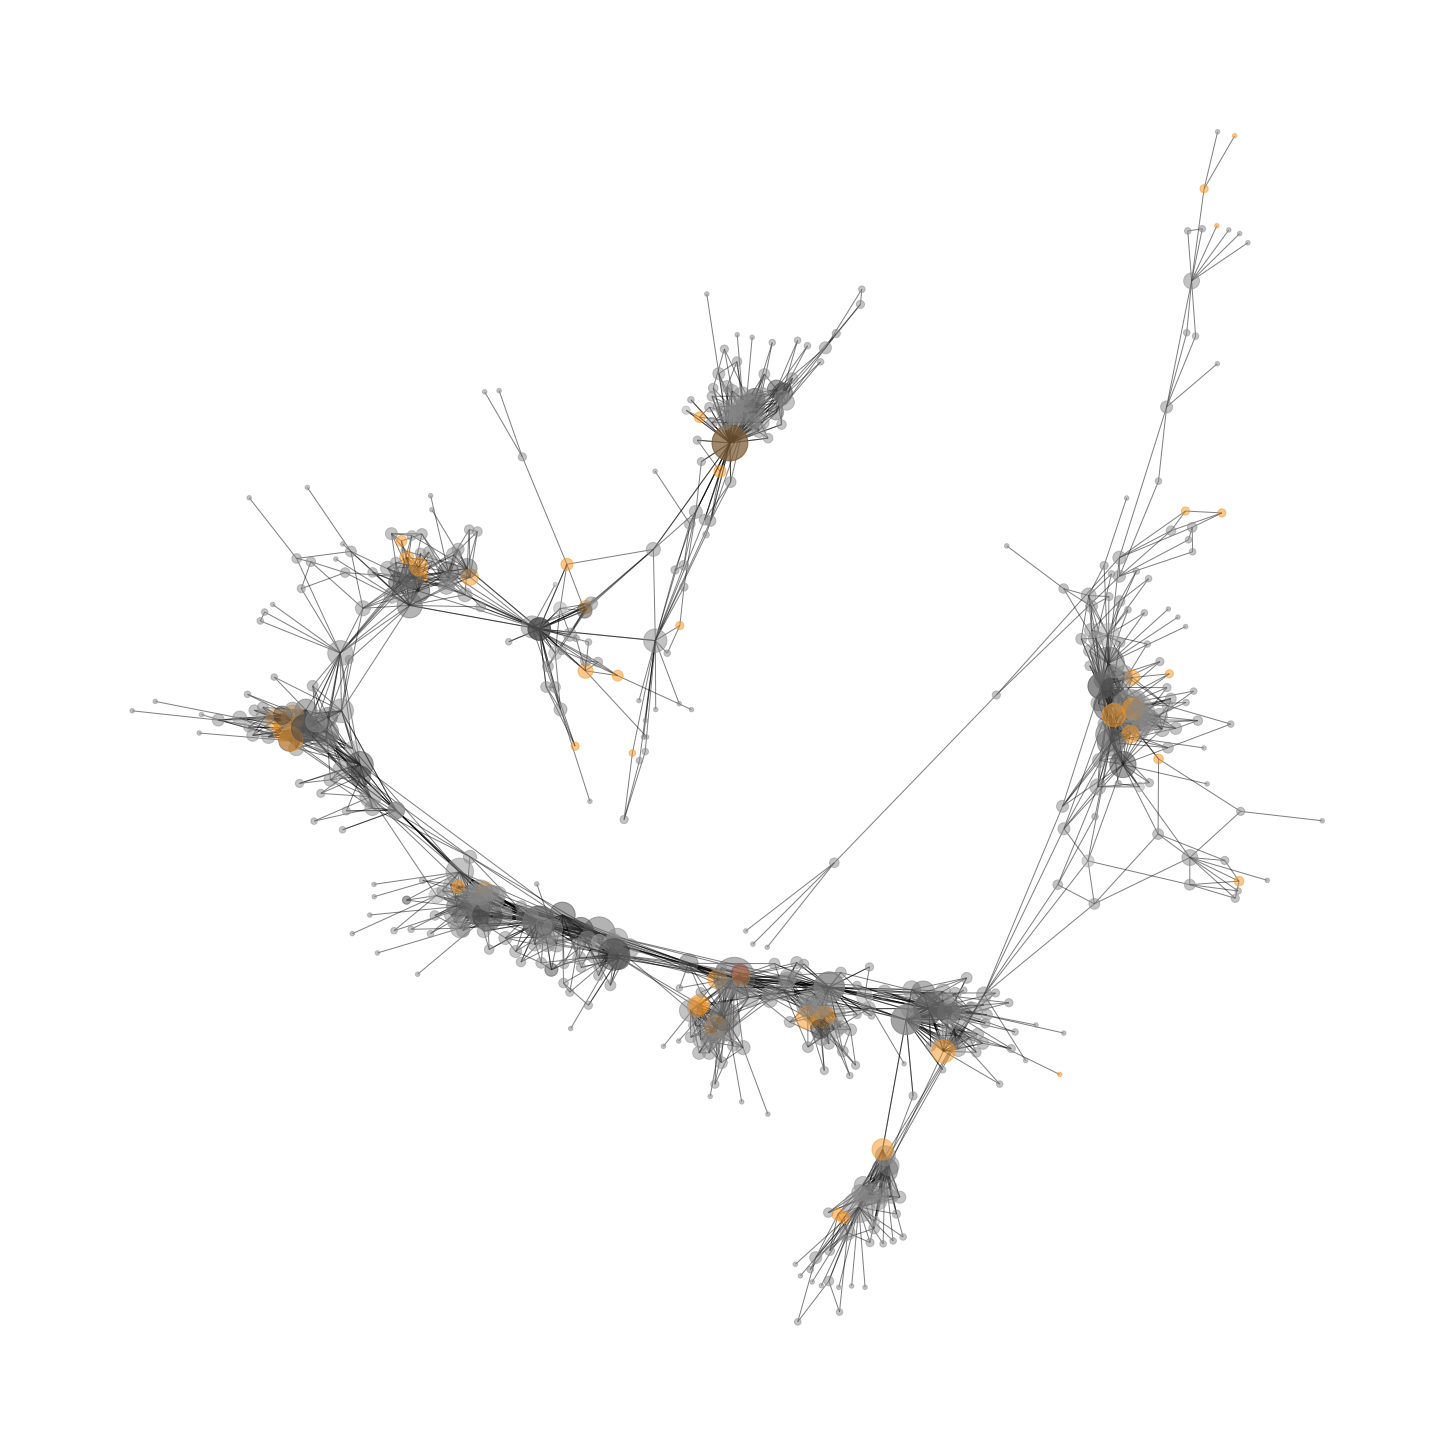

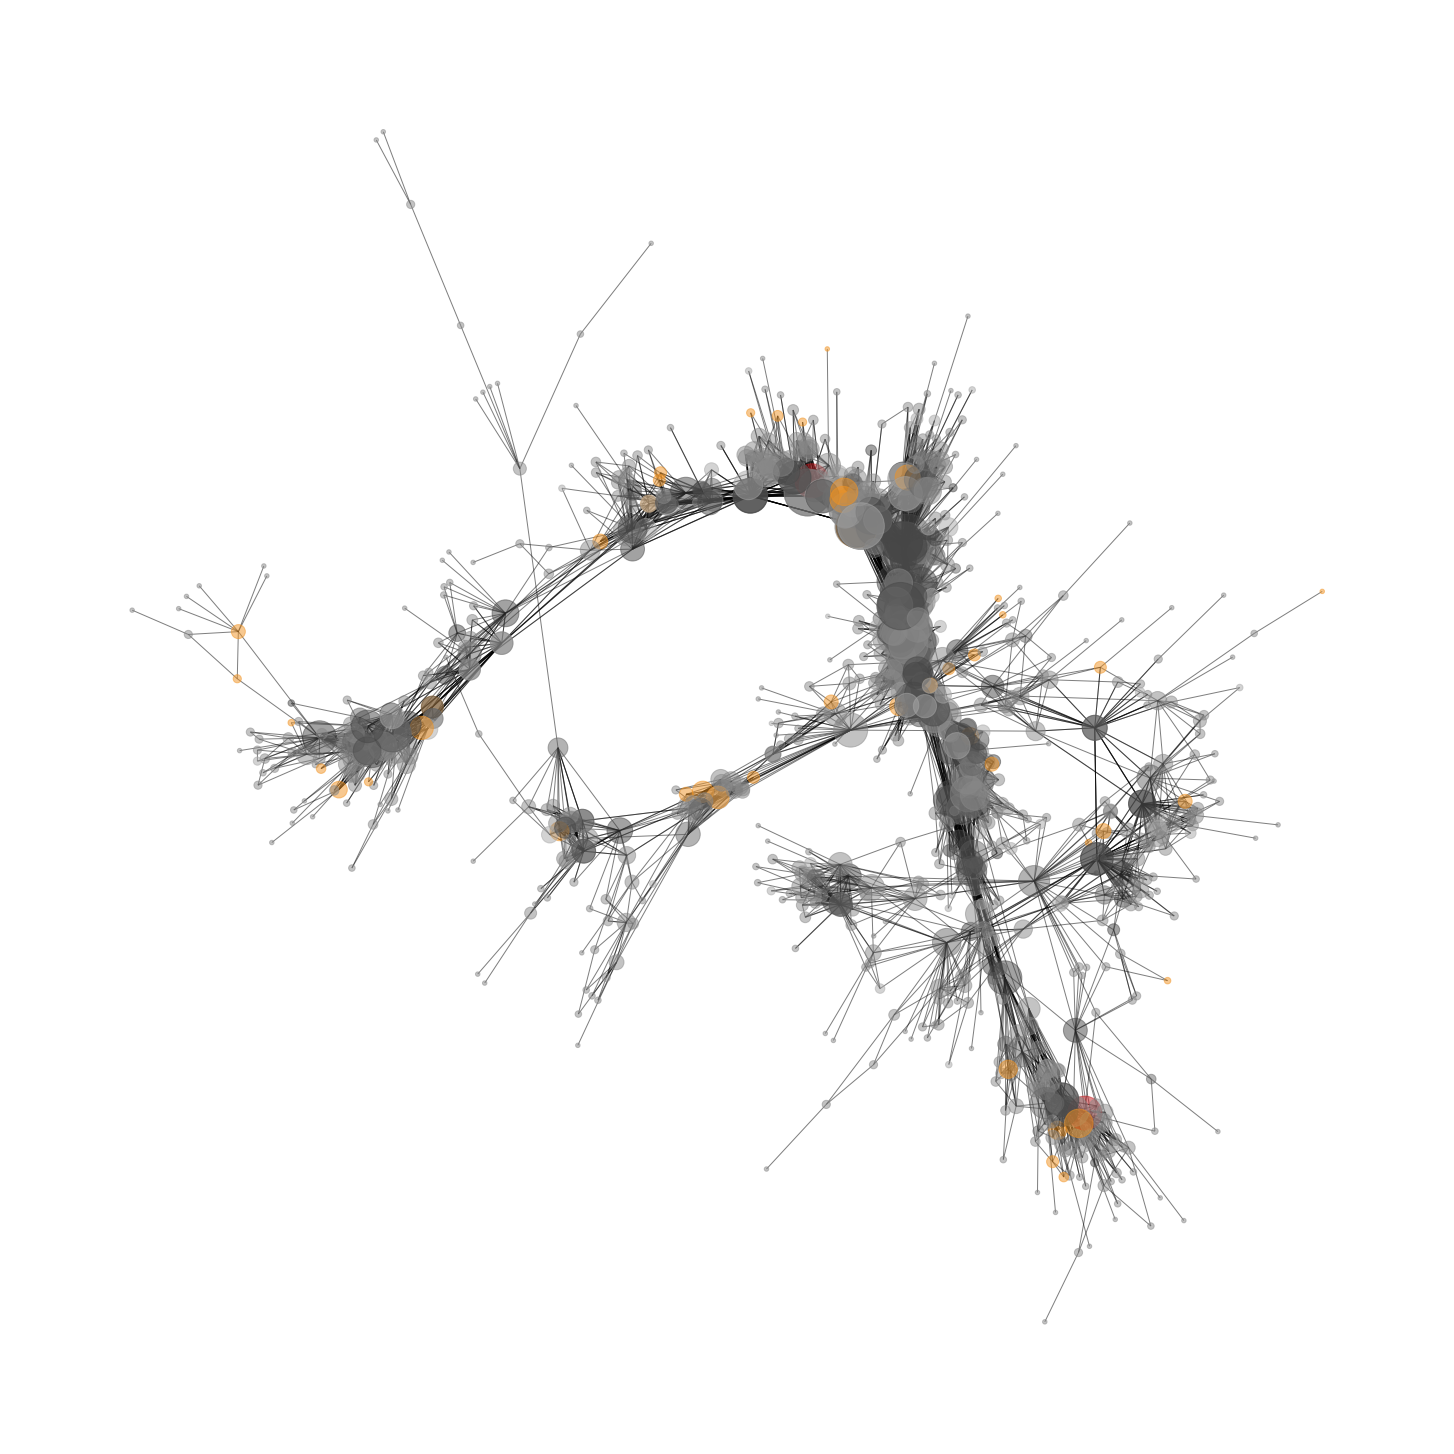

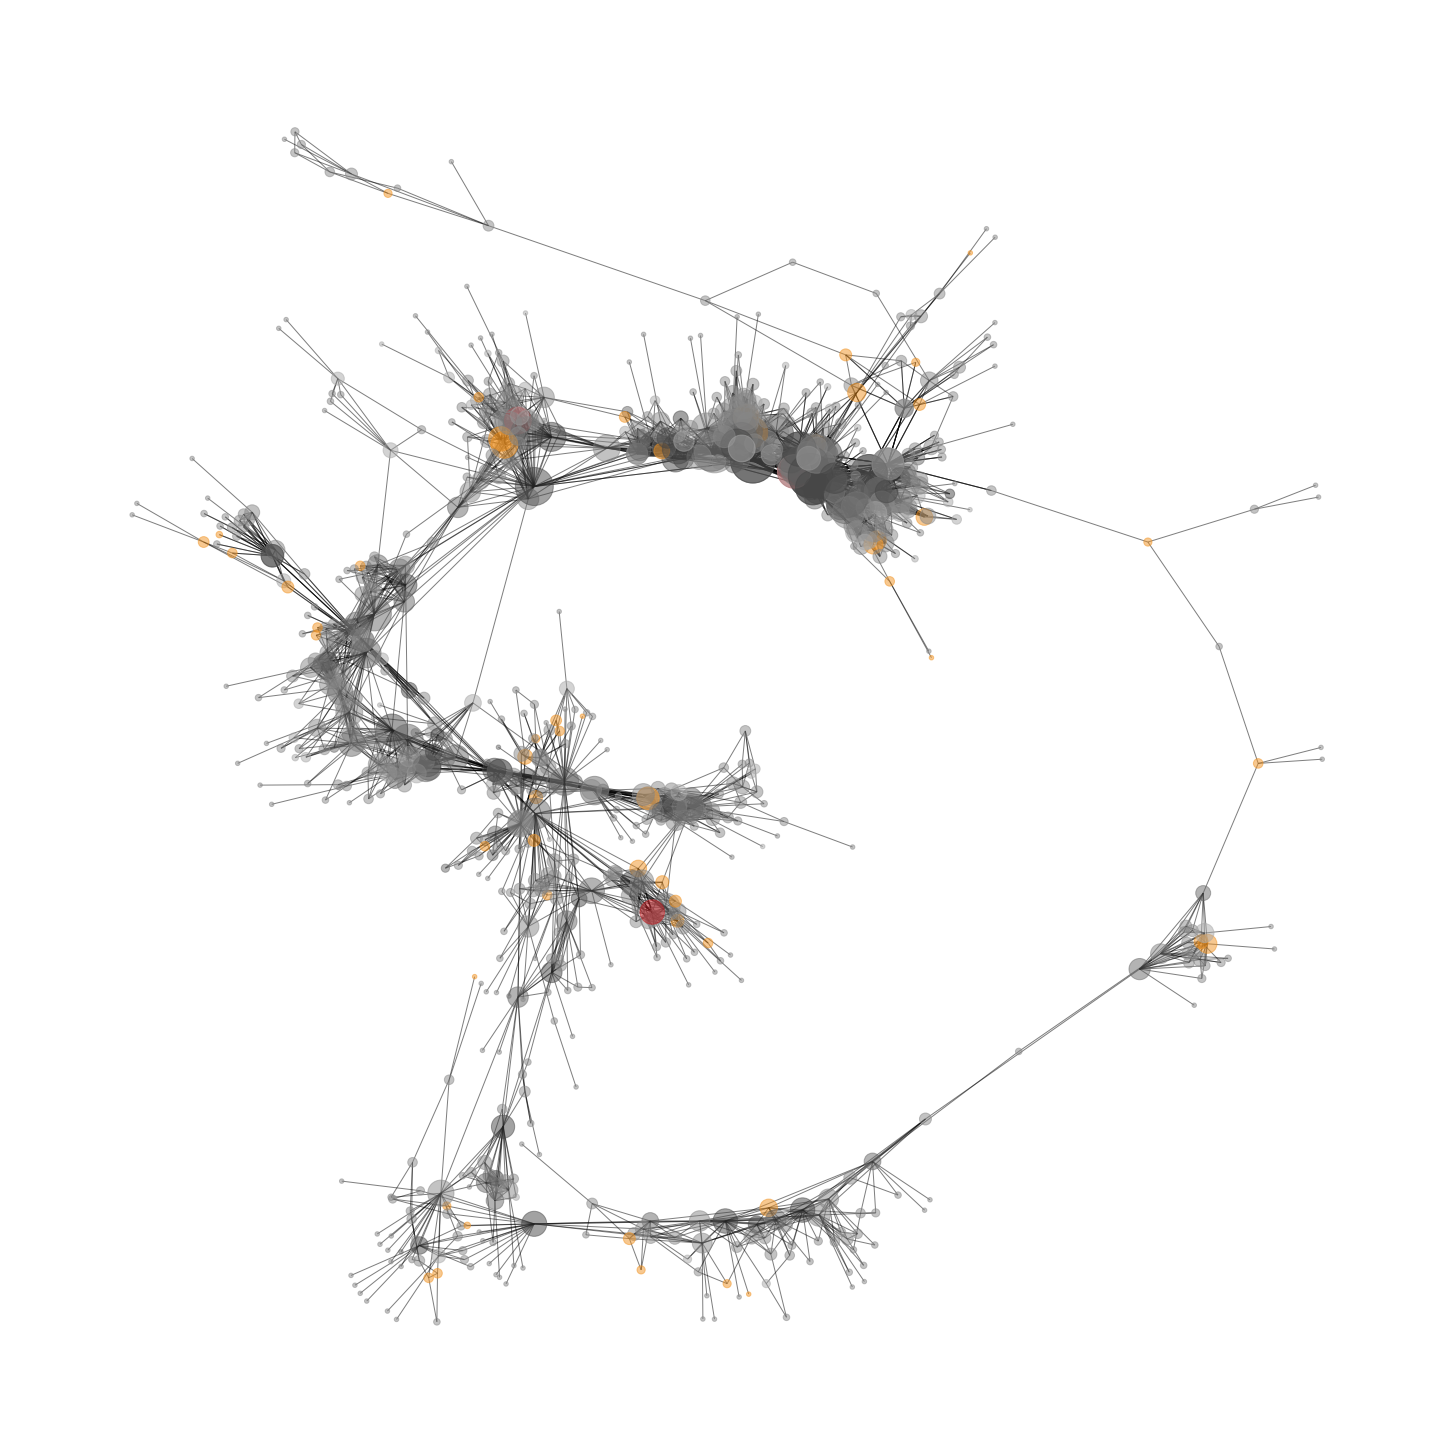

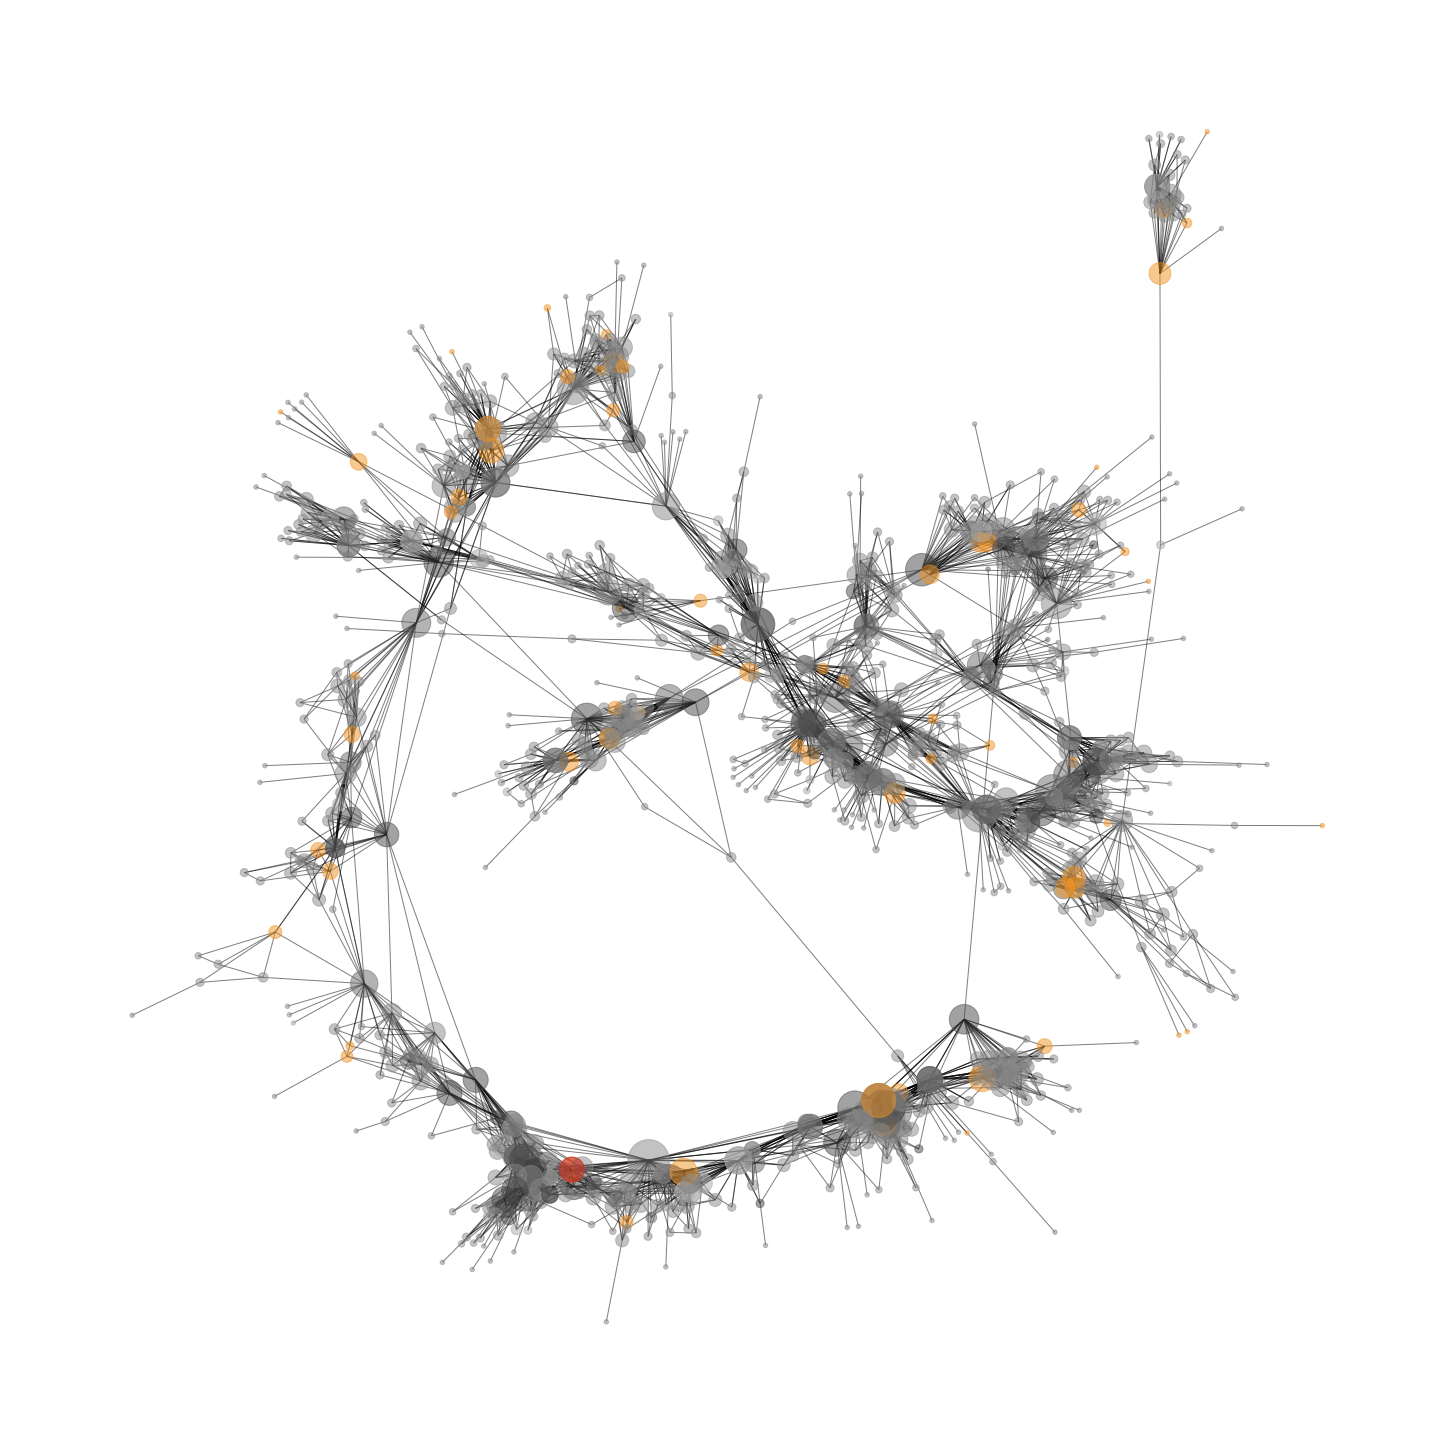

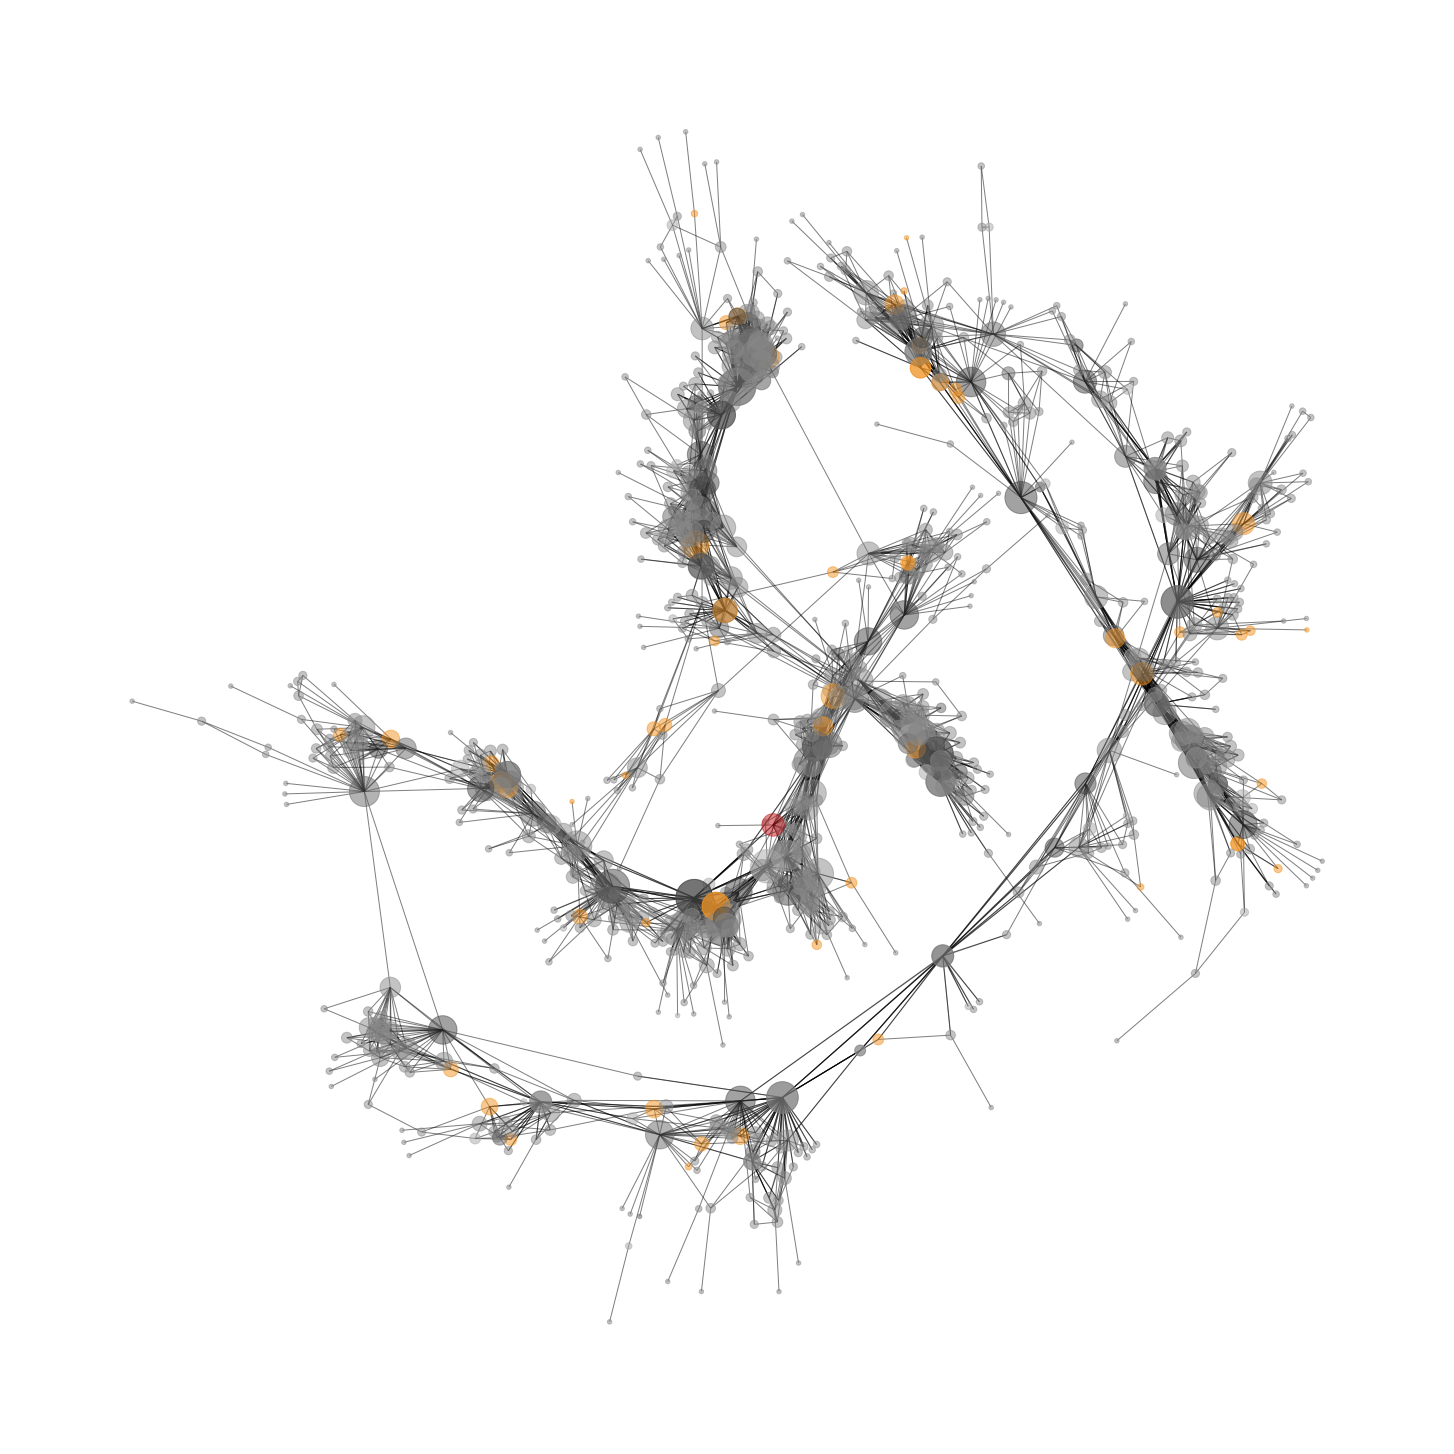

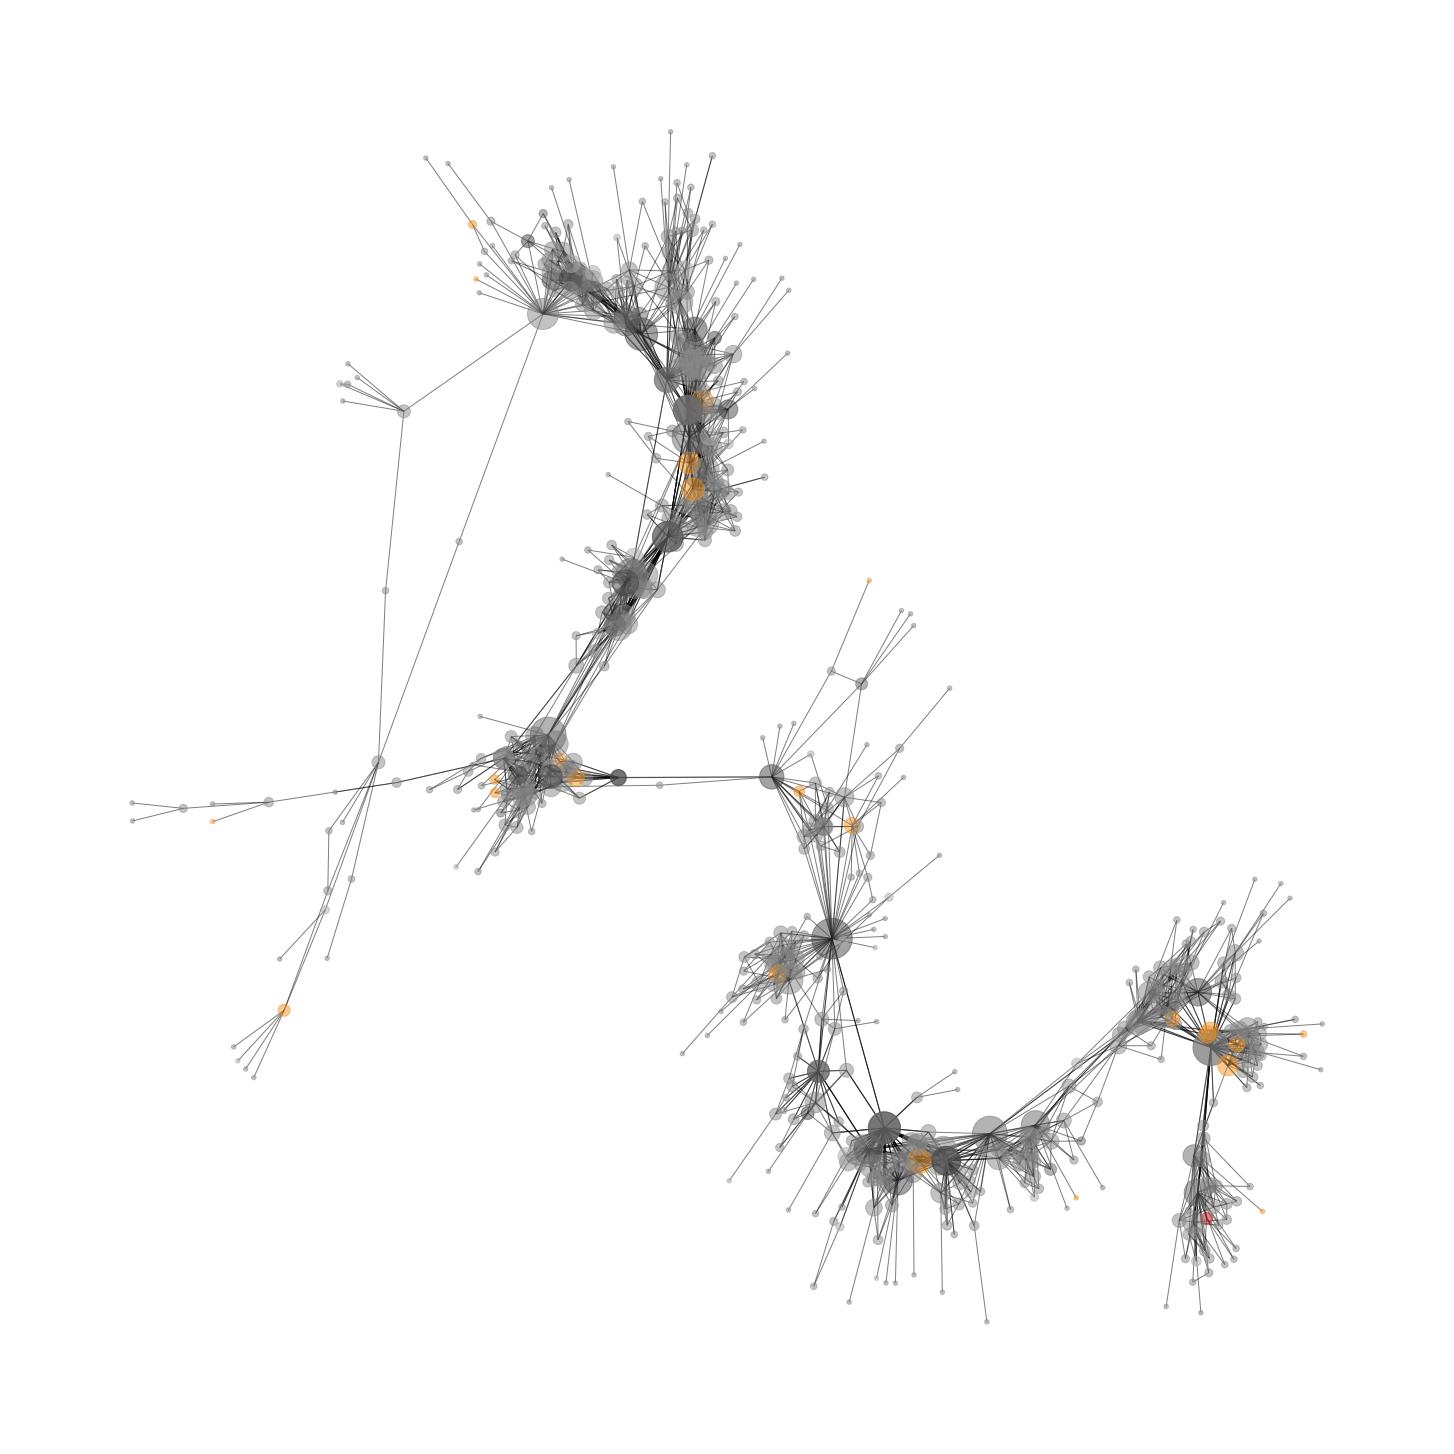

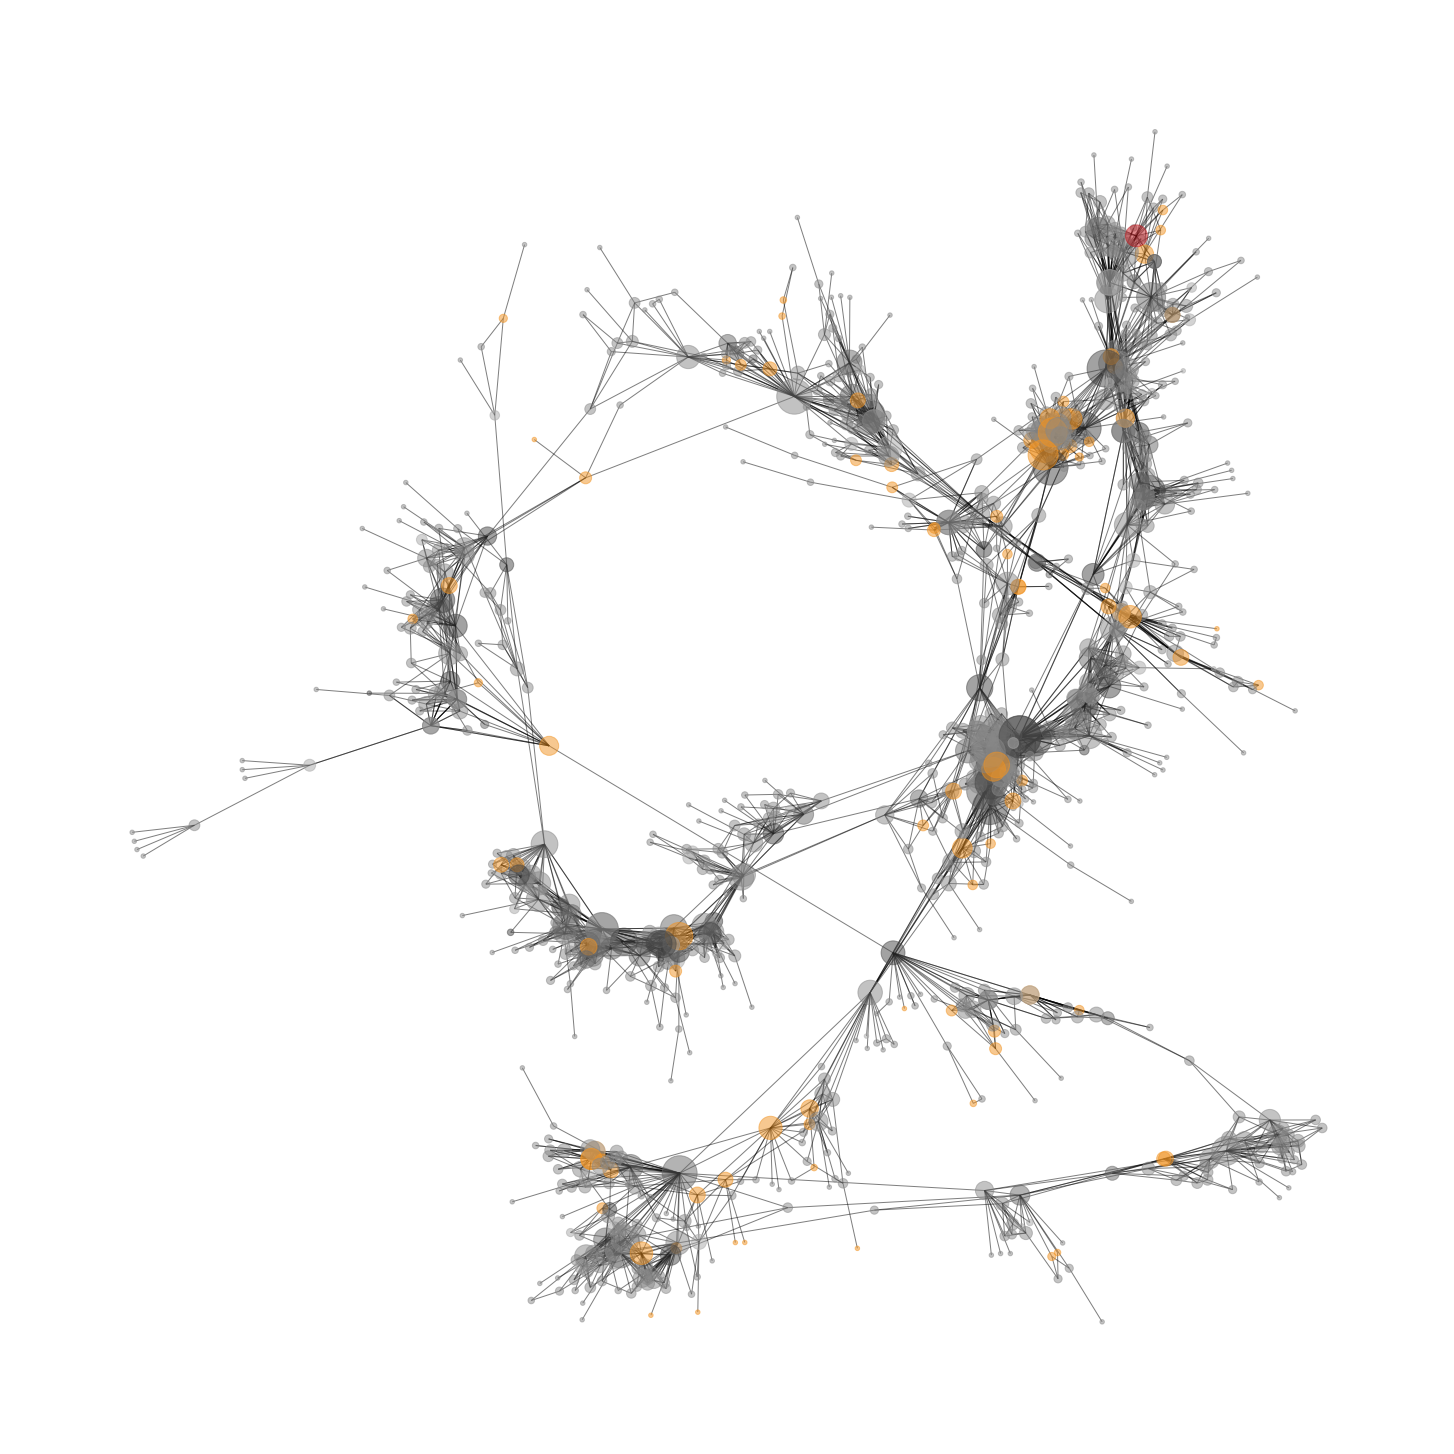

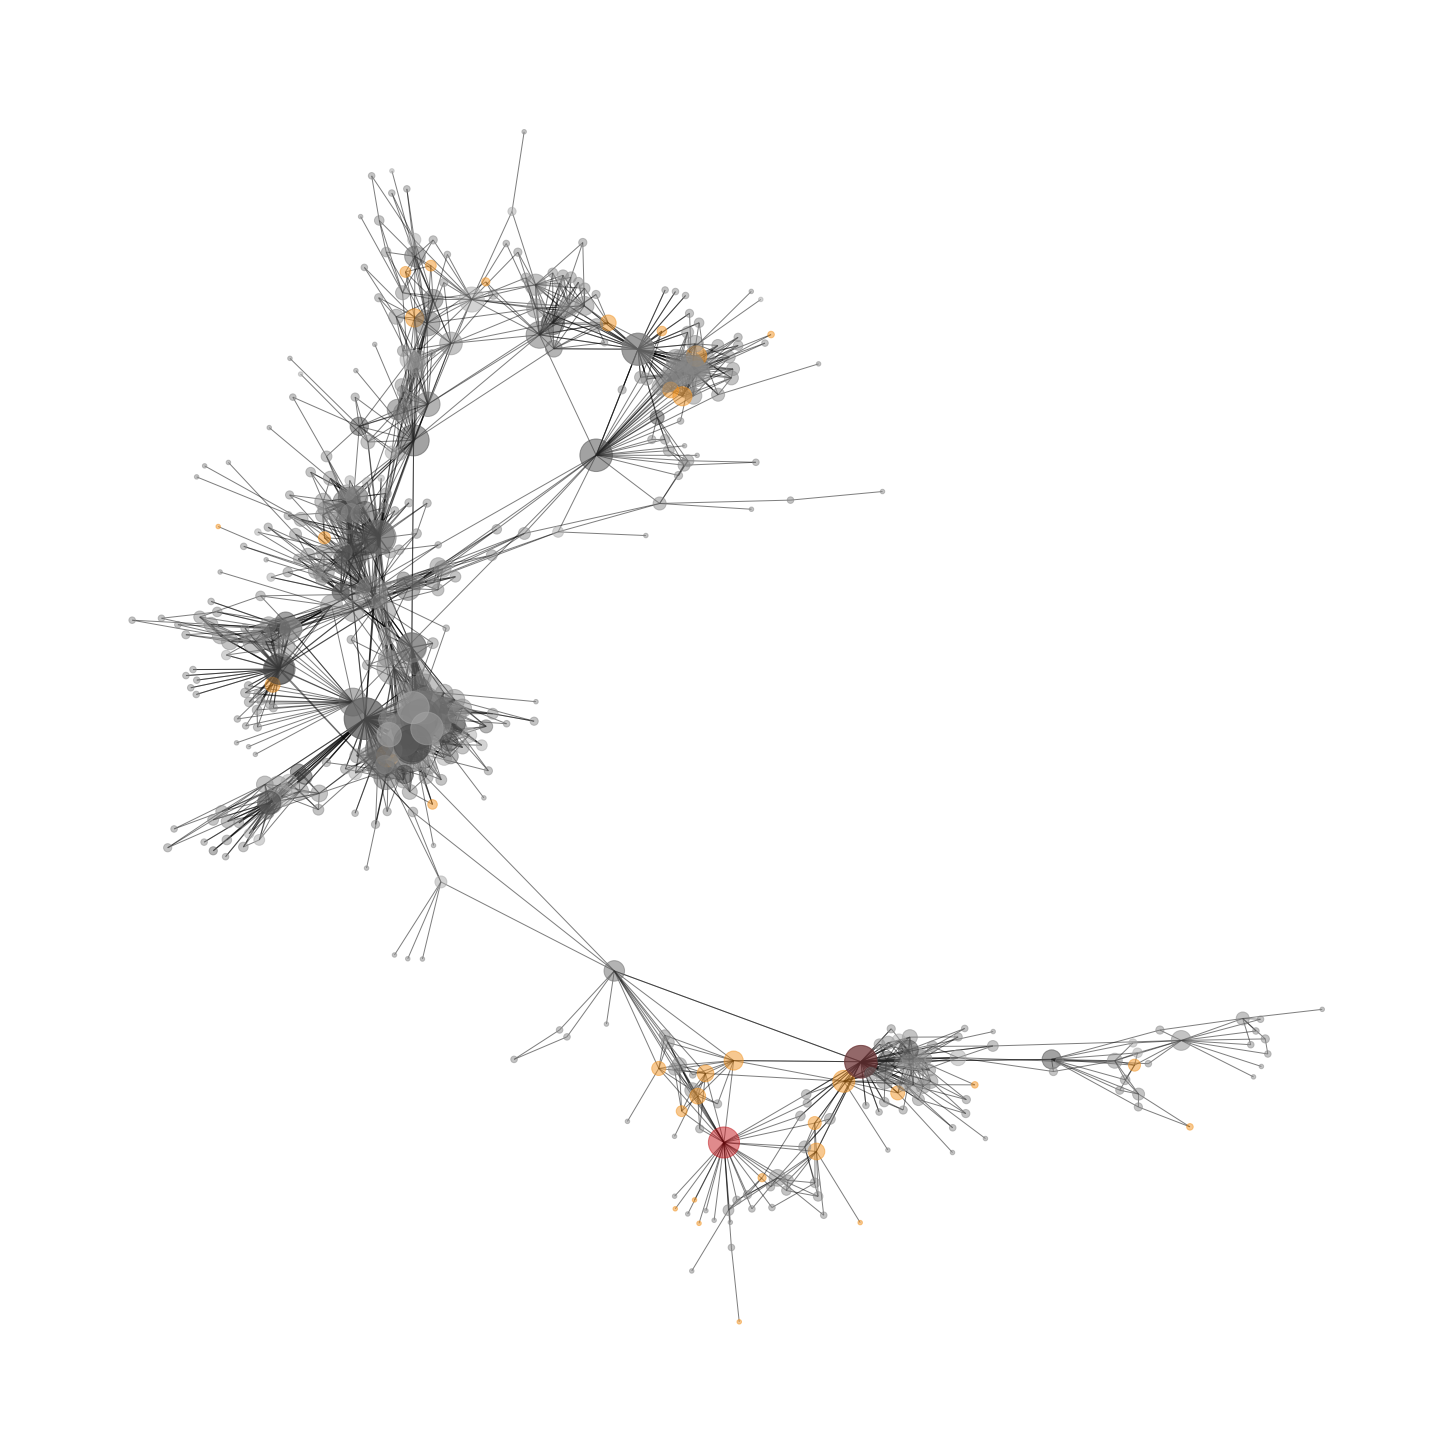

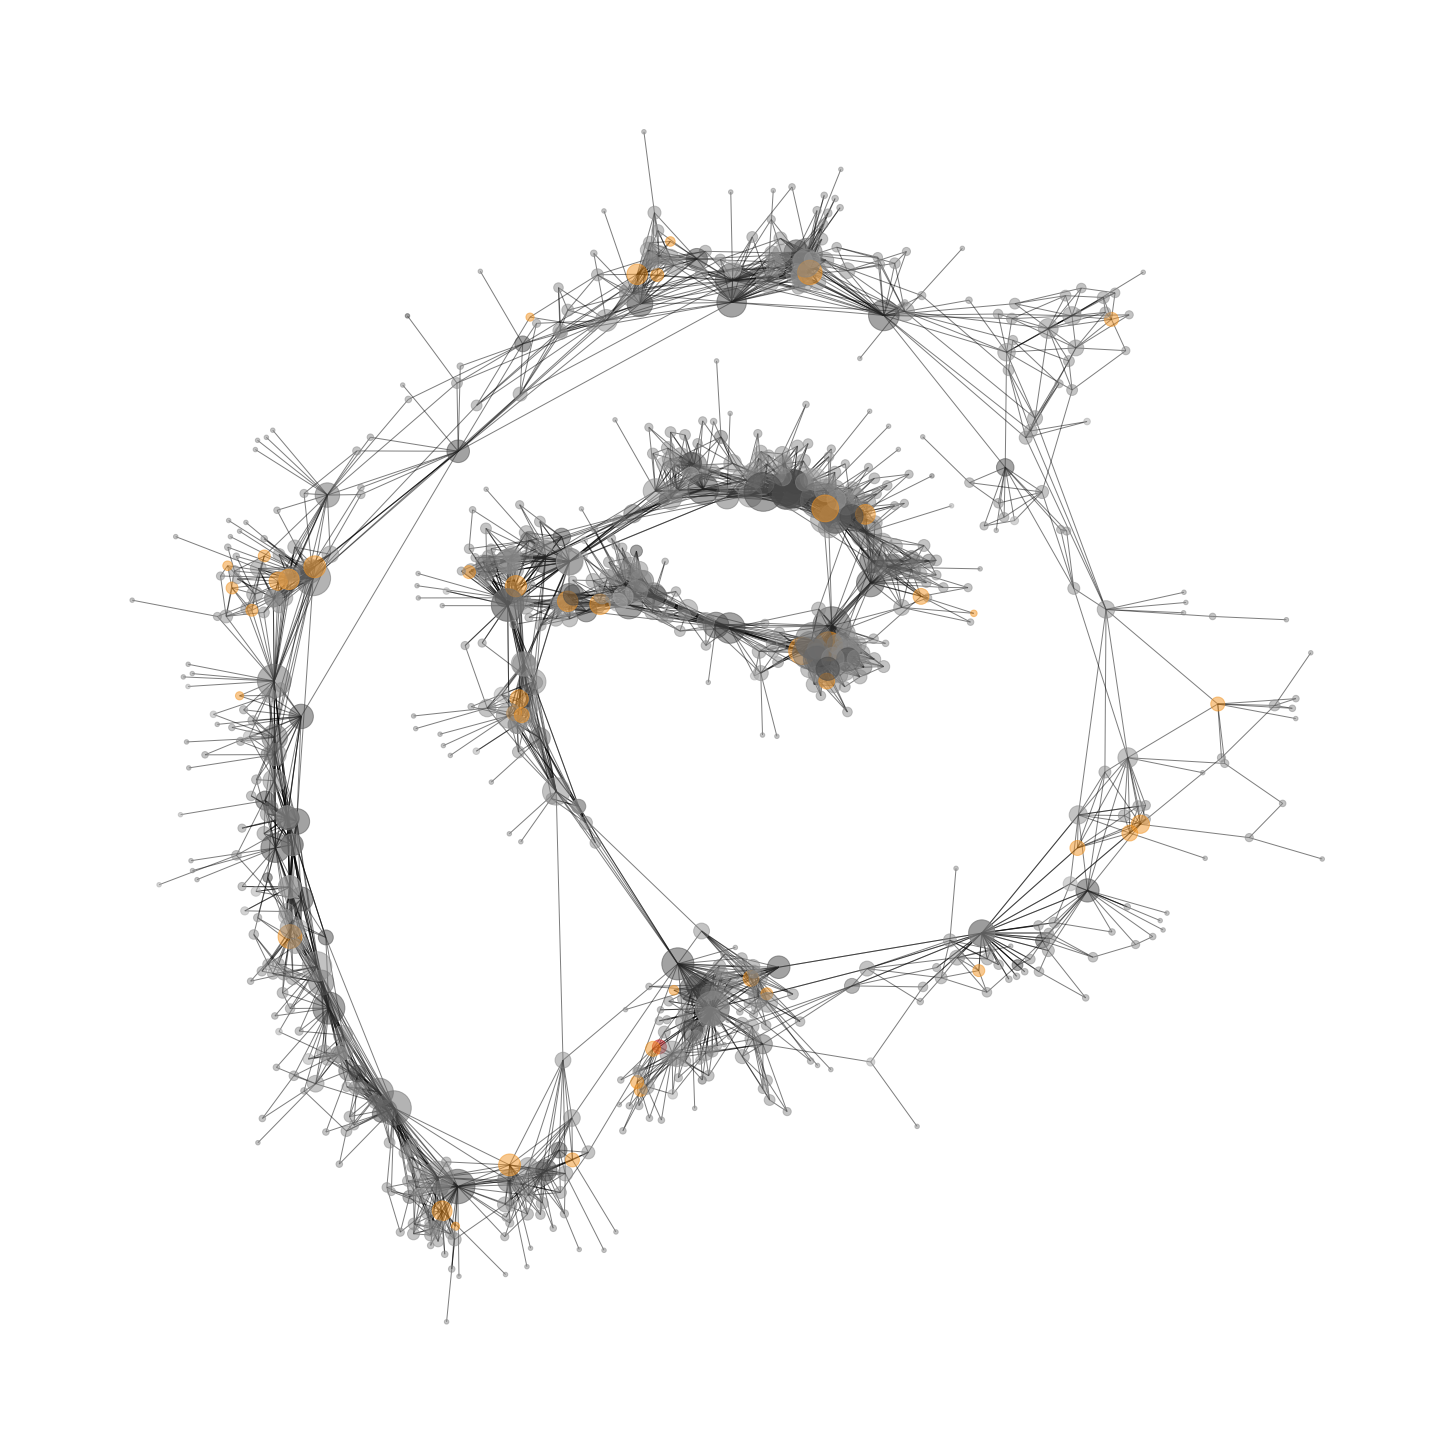

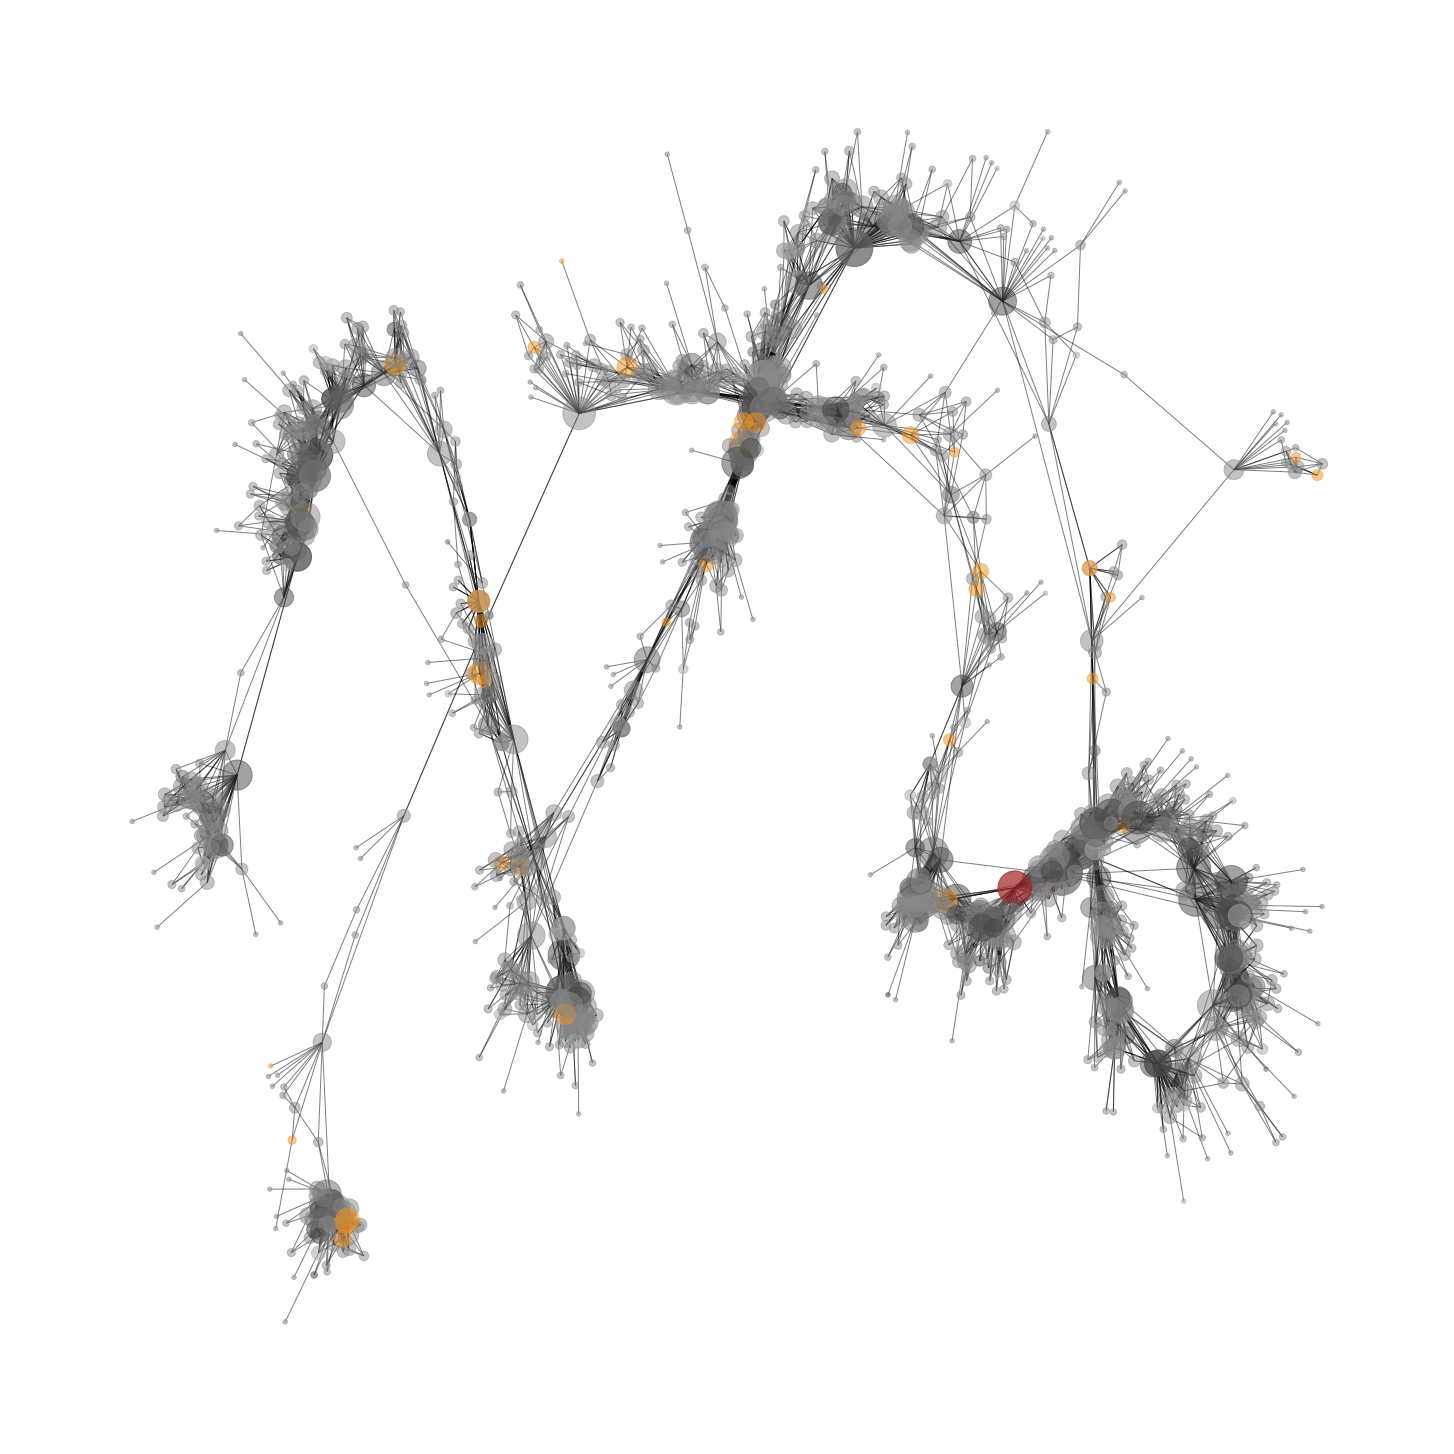

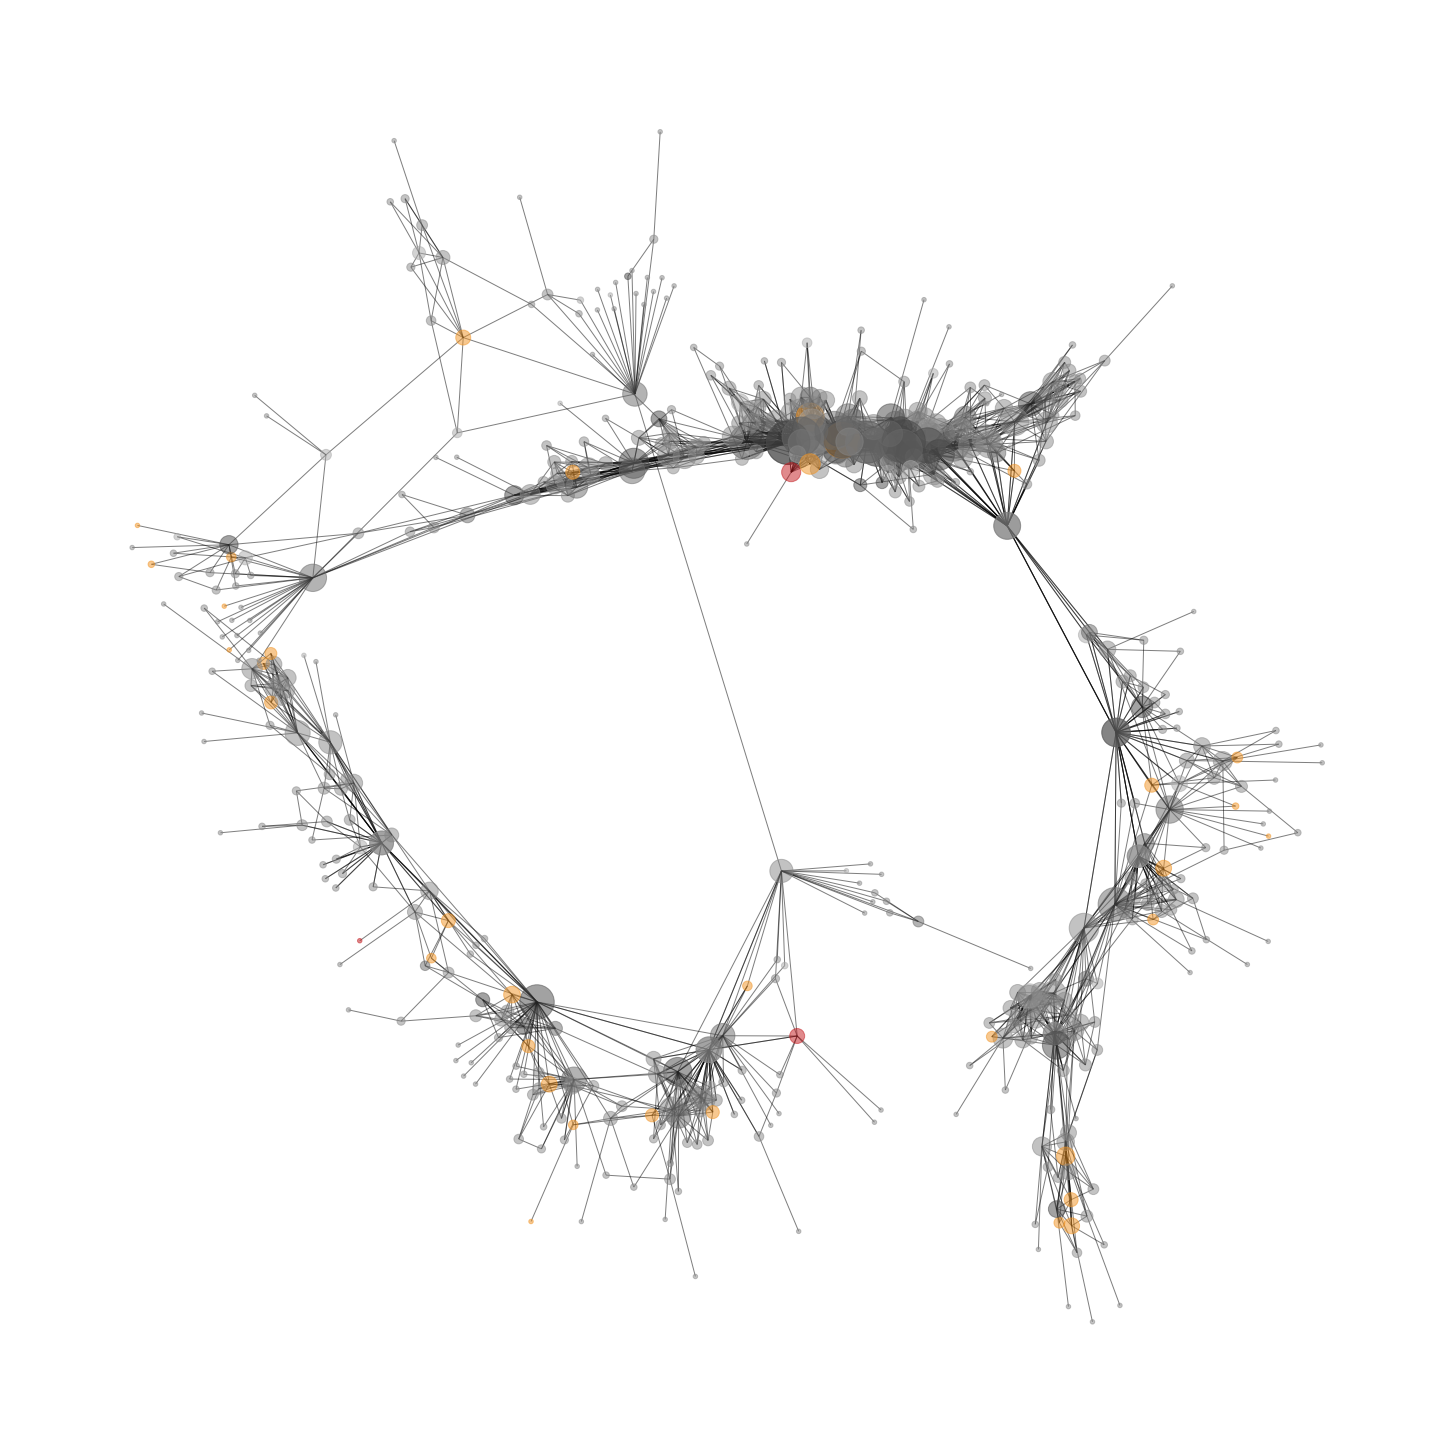

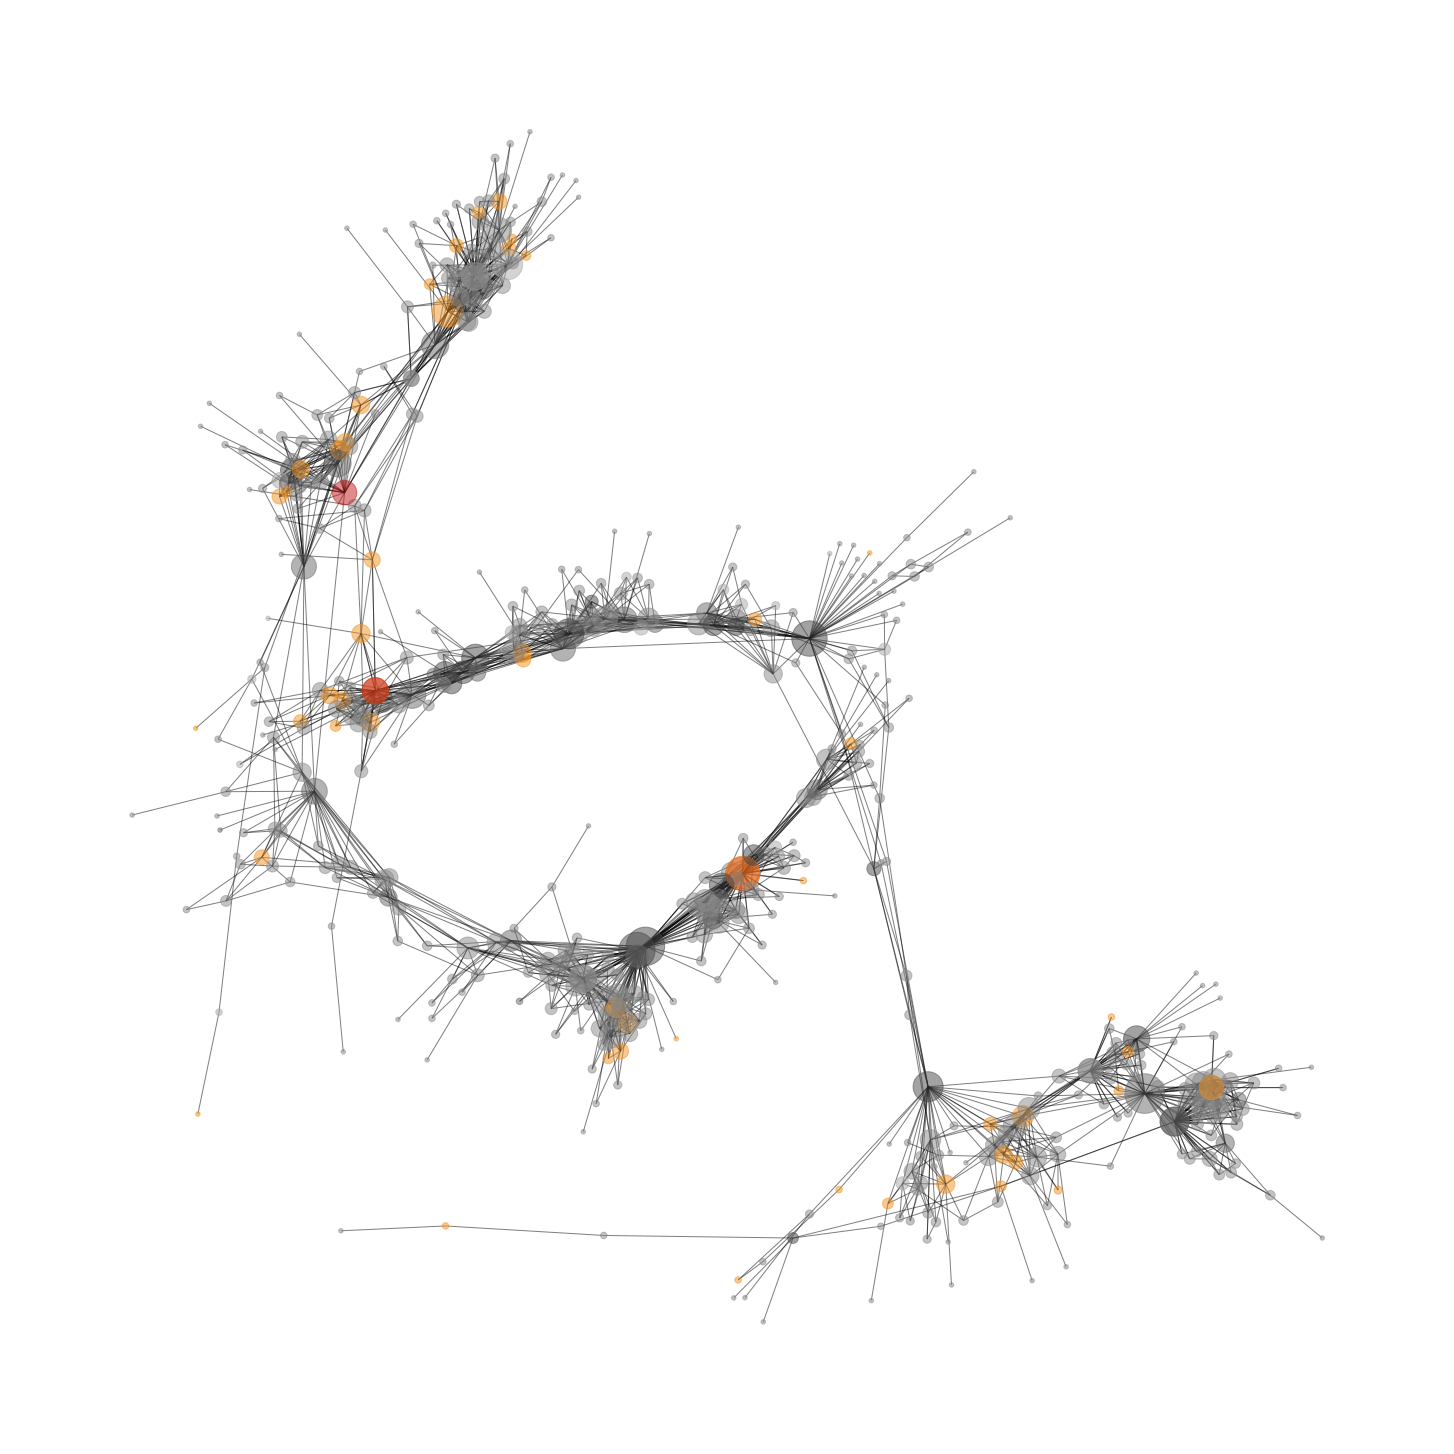

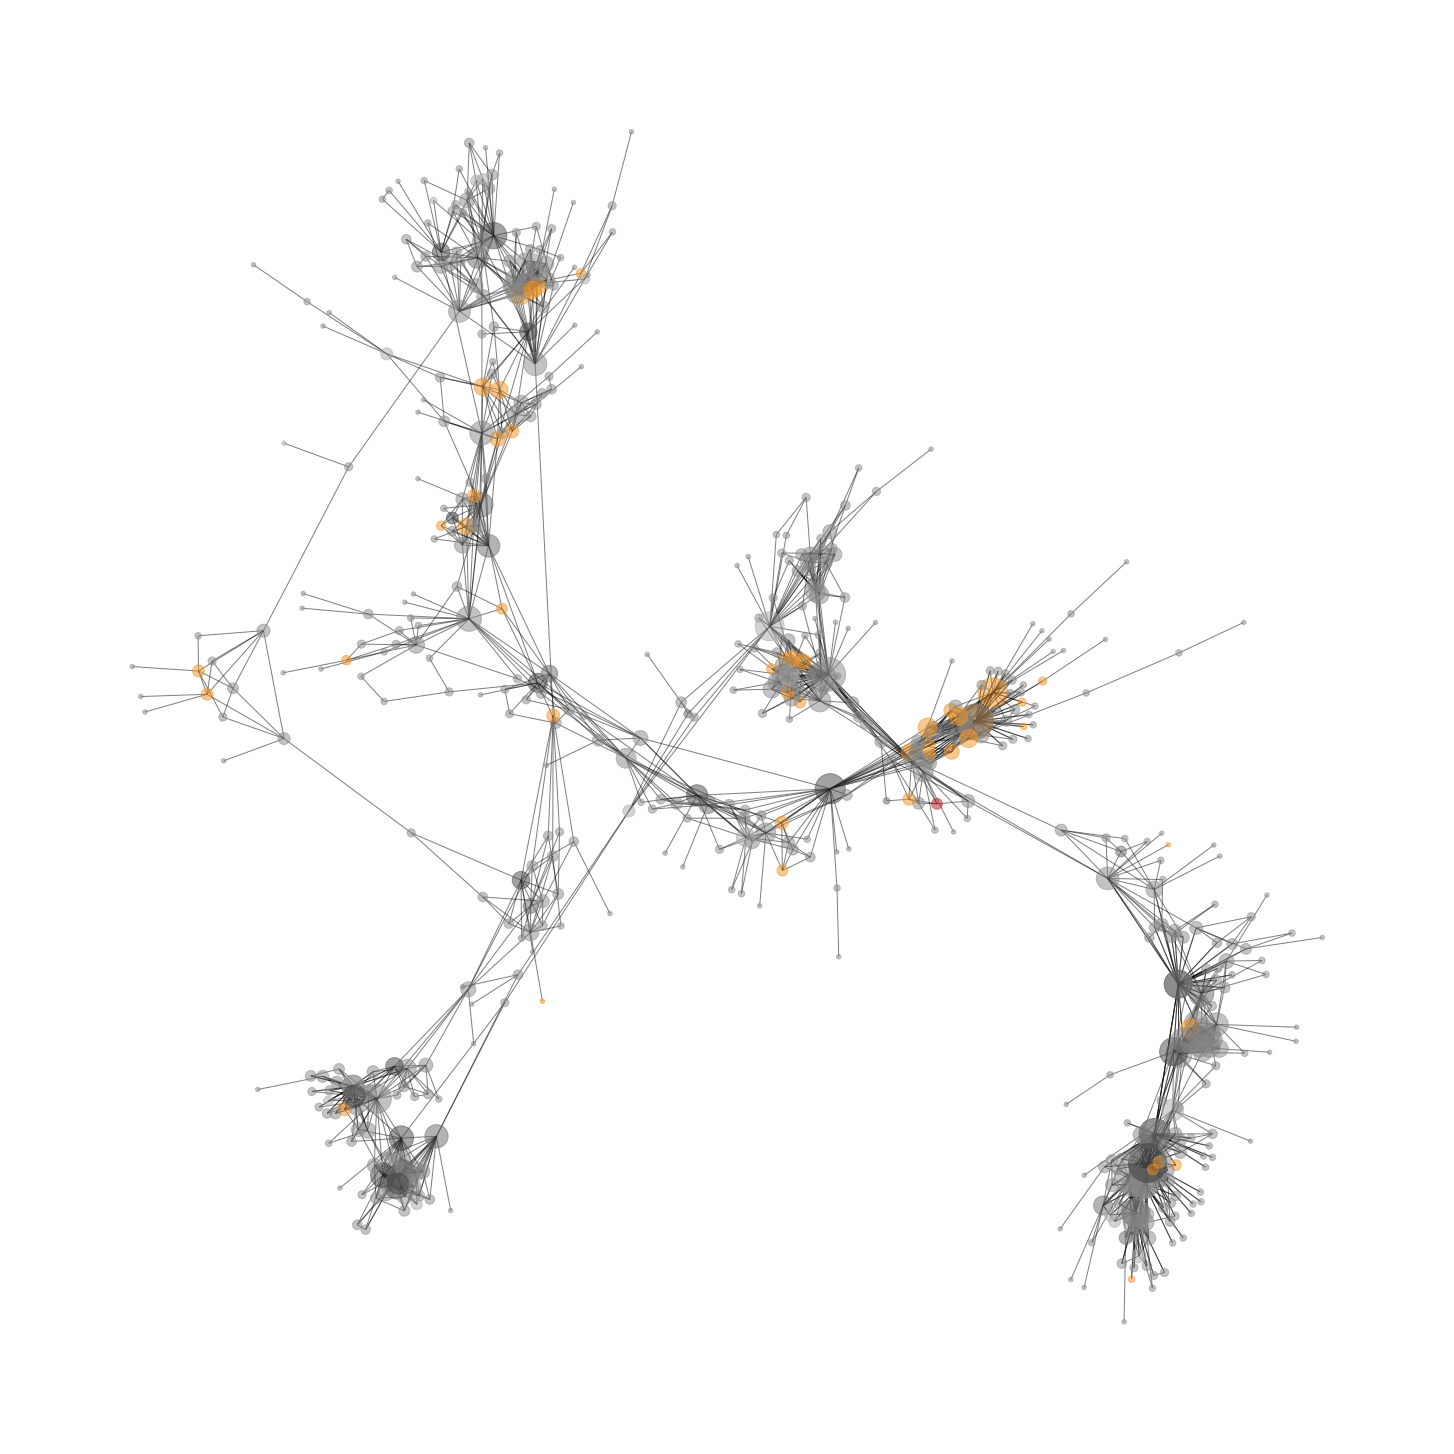

In [5]:
gs = [G.subgraph(g) for g in list(nx.connected_components(G))]

for g in gs:


    if len(g.nodes) < 500:
        continue


    if sum([MAPcl[n] == 'ANDR' for n in g.nodes]) < 1:
        continue
    

    plt.figure(figsize=[20,20])

    nx.draw(g,
            node_color=dict(g.nodes(data='color')).values(), 
            node_size=20*np.array(list(dict(g.degree()).values()))**1.1,
            alpha=0.5
        )
